In [42]:
import matplotlib.pyplot as plt
!pip3 install pyclustering prettytable

In [43]:
%load_ext autoreload
%autoreload 2

# Imports

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from clusteringUtilities import *

In [45]:
DATA_PATH = get_path()

In [46]:
df_indicators = pd.read_csv(DATA_PATH + 'indicators_clean.csv', sep='#')
df_users = pd.read_csv(DATA_PATH + 'users_clean.csv', sep='#')

In [47]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140543 entries, 0 to 140542
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           140543 non-null  object 
 1   n_tweets                          140543 non-null  int64  
 2   2012_tweets                       140543 non-null  int64  
 3   2013_tweets                       140543 non-null  int64  
 4   2014_tweets                       140543 non-null  int64  
 5   2015_tweets                       140543 non-null  int64  
 6   2016_tweets                       140543 non-null  int64  
 7   2017_tweets                       140543 non-null  int64  
 8   2018_tweets                       140543 non-null  int64  
 9   2019_tweets                       140543 non-null  int64  
 10  2020_tweets                       140543 non-null  int64  
 11  mean_length                       140543 non-null  f

In [48]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [49]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                11508 non-null  object 
 1   name                              11507 non-null  object 
 2   lang                              11508 non-null  object 
 3   bot                               11508 non-null  int64  
 4   user_subscription                 11508 non-null  object 
 5   statuses_count                    11508 non-null  float64
 6   user_subscription_in_secs         11508 non-null  int64  
 7   user_id                           11504 non-null  object 
 8   n_tweets                          11504 non-null  float64
 9   2012_tweets                       11504 non-null  float64
 10  2013_tweets                       11504 non-null  float64
 11  2014_tweets                       11504 non-null  float64
 12  2015

Drop categorical columns

In [50]:
non_numeric_attributes = ['id', 'user_id', 'name', 'lang', 'user_subscription', 'bot']
numeric_attributes = [attr for attr in df_merge.columns if attr not in non_numeric_attributes]
date_attributes = ['user_subscription_in_secs','publication_date_in_secs_mean','publication_date_in_secs_std']
#df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

We try to understand which attributes should be transformed in log scale by analyzing the boxplots

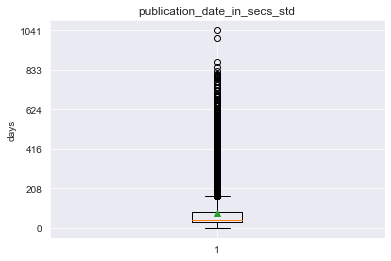

In [51]:
plot_boxplot(df_merge, 'publication_date_in_secs_std', timedelta=True)

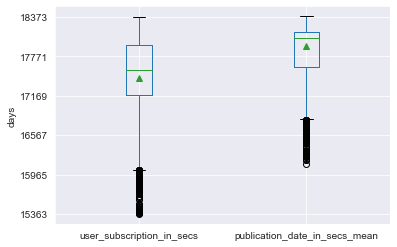

In [52]:
df_merge[['user_subscription_in_secs','publication_date_in_secs_mean']].boxplot(showmeans=True)
timedelta_labels(df_merge, 'user_subscription_in_secs', axis='y')

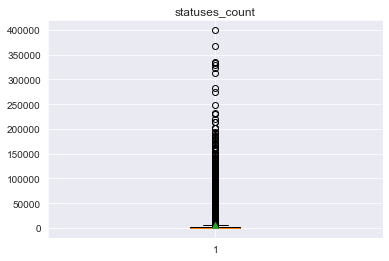

In [53]:
plot_boxplot(df_merge, 'statuses_count')

<AxesSubplot:>

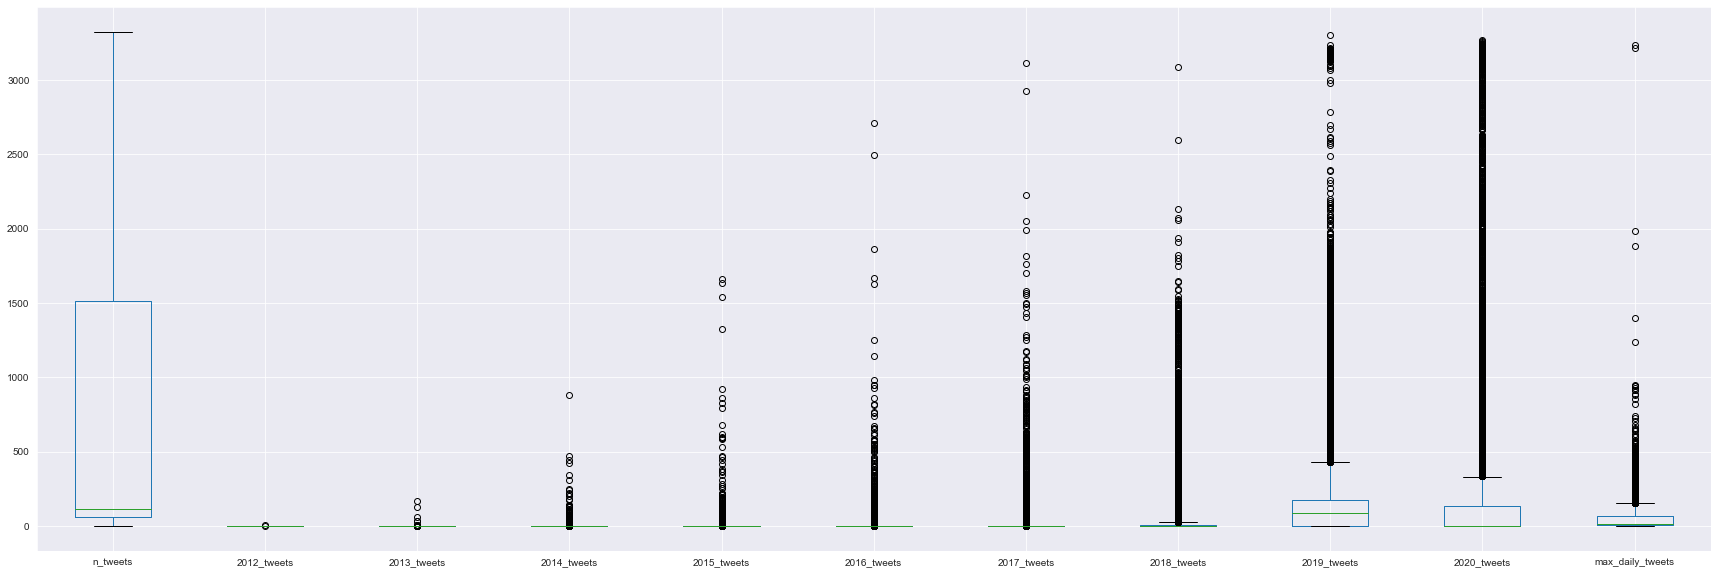

In [54]:
n_tweets_attrs = [attr for attr in df_merge.columns if '_tweets' in attr and 'density' not in attr]
plt.figure(figsize=(30, 10))
df_merge.boxplot(n_tweets_attrs)

<AxesSubplot:>

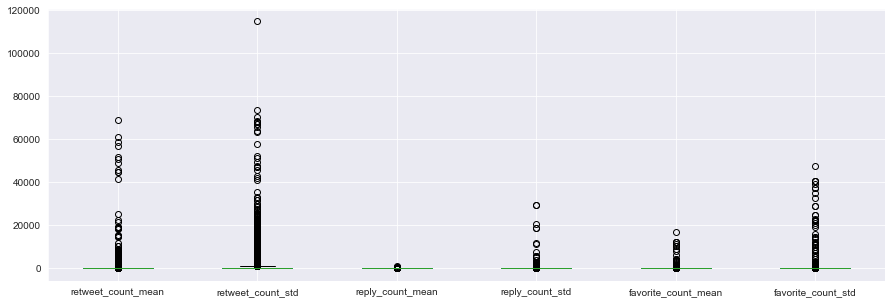

In [55]:
mean_count_attrs = [attr for attr in df_merge.columns if 'count_mean' in attr or  'count_std' in attr]
plt.figure(figsize=(15, 5))
df_merge.boxplot(mean_count_attrs)

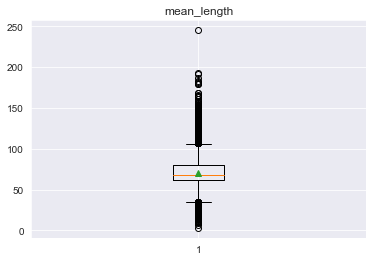

In [56]:
plot_boxplot(df_merge, 'mean_length')

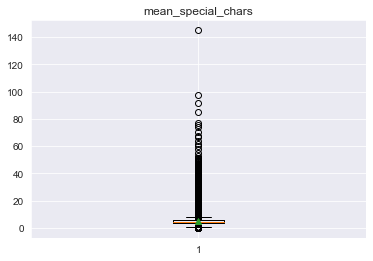

In [57]:
plot_boxplot(df_merge, 'mean_special_chars')

(array([1, 2, 3, 4, 5, 6]),
 [Text(1, 0, 'num_hashtags_mean'),
  Text(2, 0, 'num_hashtags_std'),
  Text(3, 0, 'num_urls_mean'),
  Text(4, 0, 'num_urls_std'),
  Text(5, 0, 'num_mentions_mean'),
  Text(6, 0, 'num_mentions_std')])

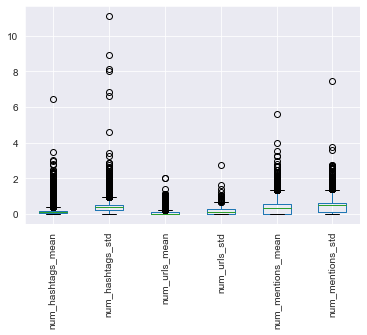

In [58]:
tweet_stats_attributes = ['num_hashtags_mean','num_hashtags_std','num_urls_mean','num_urls_std','num_mentions_mean','num_mentions_std']
df_merge.boxplot(tweet_stats_attributes)
plt.xticks(rotation=90)

C:\Users\al\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


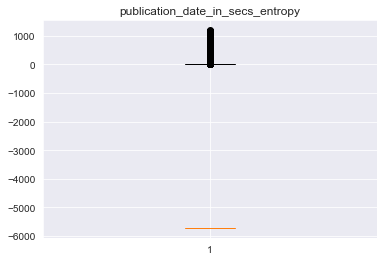

In [59]:
plot_boxplot(df_merge, 'publication_date_in_secs_entropy')

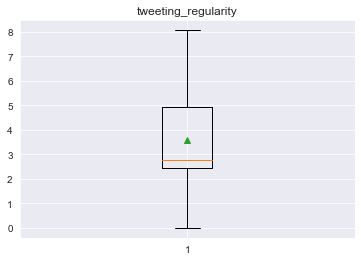

In [60]:
plot_boxplot(df_merge, 'tweeting_regularity')

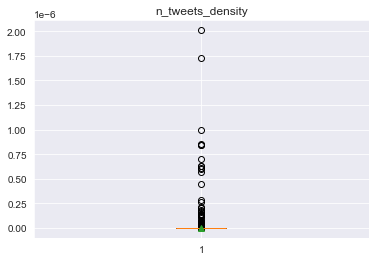

In [61]:
plot_boxplot(df_merge, 'n_tweets_density')

<AxesSubplot:>

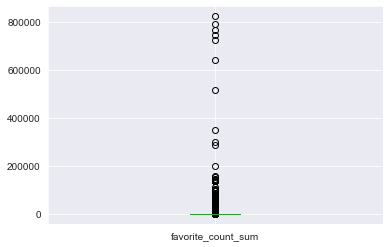

In [62]:
df_merge.boxplot(['favorite_count_sum'])

<AxesSubplot:>

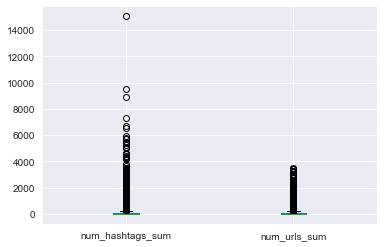

In [63]:
df_merge.boxplot(['num_hashtags_sum','num_urls_sum'])

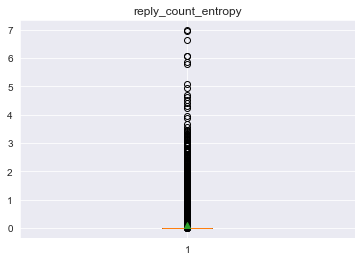

In [64]:
plot_boxplot(df_merge, 'reply_count_entropy')

<AxesSubplot:>

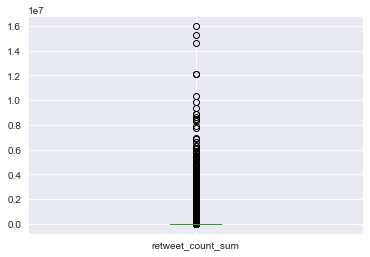

In [65]:
# plot of all the attributes not plotted above, to be sure of not forgetting anything
df_merge.boxplot([attr for attr in df_merge.columns if attr not in date_attributes+non_numeric_attributes+['statuses_count','n_tweets','mean_length','tweeting_regularity','publication_date_in_secs_entropy','n_tweets_density','mean_special_chars','num_hashtags_sum','num_urls_sum','favorite_count_sum','reply_count_entropy']+n_tweets_attrs+mean_count_attrs+tweet_stats_attributes])

In [66]:
# To understand which attribute should be transformed in log scale
not_log = ['publication_date_in_secs_mean','user_subscription_in_secs', 'mean_length','tweeting_regularity']
attrs_to_log = [c for c in df_merge.columns if c not in not_log+non_numeric_attributes]

In [67]:
# Select values to log
df_merge_log = df_merge[attrs_to_log]

# Replace NaN values in variance with 0
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)
df_merge_log = df_merge_log.fillna(value=0)

# Normalization of values

In [68]:
def to_log(df, attr):
    df[attr] = np.log(df[attr].values)
    df[attr] = df[attr].replace(-np.inf, 0)
    df[attr] = df[attr].fillna(value=0)
    return df[attr]

In [69]:
for attr in attrs_to_log:
    df_merge_log[attr] = to_log(df_merge_log, attr)

C:\Users\al\AppData\Local\Temp\ipykernel_36156\1059147254.py:2: RuntimeWarning: divide by zero encountered in log
  df[attr] = np.log(df[attr].values)
C:\Users\al\AppData\Local\Temp\ipykernel_36156\1059147254.py:2: RuntimeWarning: invalid value encountered in log
  df[attr] = np.log(df[attr].values)


It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [70]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_log.columns:
    table.add_row([attr, df_merge_log[attr].min(), df_merge_log[attr].max()])
print(table)

+----------------------------------+---------------------+--------------------+
|               attr               |         min         |        max         |
+----------------------------------+---------------------+--------------------+
|          statuses_count          |         0.0         | 12.898106706802647 |
|             n_tweets             |         0.0         |  8.10892415597534  |
|           2012_tweets            |         0.0         | 1.9459101490553132 |
|           2013_tweets            |         0.0         | 5.1298987149230735 |
|           2014_tweets            |         0.0         | 6.785587645007929  |
|           2015_tweets            |         0.0         | 7.415776975415394  |
|           2016_tweets            |         0.0         | 7.903965634032166  |
|           2017_tweets            |         0.0         | 8.043663352393944  |
|           2018_tweets            |         0.0         | 8.034306936339489  |
|           2019_tweets            |    

In [71]:
# Normalizzare i valori in log
df_merge_log[not_log] = df_merge[not_log]
scaler = MinMaxScaler()
scaler.fit(df_merge_log.values)
df_merge_scaled = scaler.transform(df_merge_log.values)
df_merge_scaled = pd.DataFrame(df_merge_scaled, columns=df_merge_log.columns)

In [72]:
from prettytable import PrettyTable

table = PrettyTable(field_names=['attr', 'min', 'max'])
for attr in df_merge_scaled.columns:
    table.add_row([attr, df_merge_scaled[attr].min(), df_merge_scaled[attr].max()])
print(table)

+----------------------------------+-----+--------------------+
|               attr               | min |        max         |
+----------------------------------+-----+--------------------+
|          statuses_count          | 0.0 |        1.0         |
|             n_tweets             | 0.0 |        1.0         |
|           2012_tweets            | 0.0 |        1.0         |
|           2013_tweets            | 0.0 |        1.0         |
|           2014_tweets            | 0.0 | 0.9999999999999999 |
|           2015_tweets            | 0.0 |        1.0         |
|           2016_tweets            | 0.0 |        1.0         |
|           2017_tweets            | 0.0 |        1.0         |
|           2018_tweets            | 0.0 |        1.0         |
|           2019_tweets            | 0.0 |        1.0         |
|           2020_tweets            | 0.0 |        1.0         |
|        mean_special_chars        | 0.0 |        1.0         |
|   publication_date_in_secs_std   | 0.0

In [73]:
df_merge_scaled[non_numeric_attributes] = df_merge[non_numeric_attributes]

In [74]:
df_merge_scaled.fillna(0, inplace=True)

In [75]:
df_merge[numeric_attributes].fillna(0).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   statuses_count                    11508 non-null  float64
 1   user_subscription_in_secs         11508 non-null  int64  
 2   n_tweets                          11508 non-null  float64
 3   2012_tweets                       11508 non-null  float64
 4   2013_tweets                       11508 non-null  float64
 5   2014_tweets                       11508 non-null  float64
 6   2015_tweets                       11508 non-null  float64
 7   2016_tweets                       11508 non-null  float64
 8   2017_tweets                       11508 non-null  float64
 9   2018_tweets                       11508 non-null  float64
 10  2019_tweets                       11508 non-null  float64
 11  2020_tweets                       11508 non-null  float64
 12  mean

# PCA

In [76]:
df_merge_scaled[['pc1','pc2']] = PCA(n_components=2).fit_transform(df_merge_scaled[numeric_attributes])
df_merge_scaled[['pc1','pc2','bot']]

,pc1,pc2,bot
0,-0.532534,0.372873,1
1,-0.590115,0.379036,0
2,-1.011499,-0.505995,1
3,0.267505,0.477881,1
4,0.789879,0.007863,0
...,...,...,...
11503,0.924350,-0.649692,0
11504,0.529217,0.264618,0
11505,-0.809201,-0.436050,0
11506,-0.610432,0.318506,1


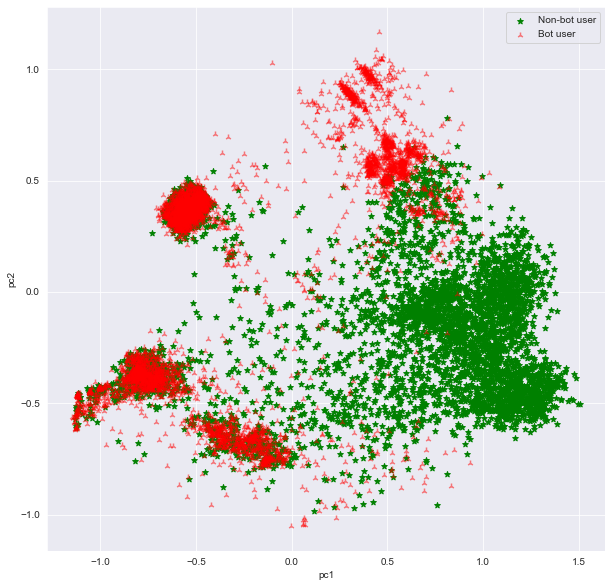

In [77]:
plt.figure(figsize=(10,10))
bot_scatter(df_merge_scaled,'pc1','pc2',path="bot_pca.png")

In [78]:
df_merge_scaled.to_csv(path_or_buf=DATA_PATH+'data_scaled_for_clustering.csv', sep='#', index=False)